In [1]:
# imports
from ReadCameraModel import ReadCameraModel
from UndistortImage import UndistortImage
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [2]:
# compute intrinsic matrix
fx, fy, cx, cy, _, LUT = ReadCameraModel('Oxford_dataset_reduced/model')

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])


In [3]:
# Load and Demosaic Images

# start by adding all images to a list of images called imgs
imgs = []

filepath = 'Oxford_dataset_reduced/images'

# Iterate through the files in the folder
for filename in os.listdir(filepath):
    # Check if the file is an image file
    if filename.endswith(('.png')):

        var_name = filename[:-4]
        # Read the image        
        img = cv2.imread(os.path.join(filepath, filename), flags=-1)

        # recolor the image
        color_image = cv2.cvtColor(img, cv2.COLOR_BayerGR2BGR)

        # undistort the image
        undistorted_image = UndistortImage(color_image,LUT)
        # Append the image to the list
        imgs.append((var_name, color_image))

# sort images based on name
imgs = sorted(imgs, key=lambda x: x[0])

# remove the name from the images so just the images remain
imgs = [x[1] for x in imgs]





In [40]:
# Keypoint Correspondences: Use SIFT in order to find good matches between images
# Estimate F
# Recover E

# list of rotation matrices for end
rot_lst = []
trans_lst = []

sift = cv2.SIFT_create()

for i in range(len(imgs)):

    if i < 376:
        img1 = imgs[i]
        img2 = imgs[i+1]

        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)


        # FLANN parameters.
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)

        # FLANN based matcher with implementation of k nearest neighbour.
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # Ratio test to filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.5 * n.distance:
                good_matches.append(m)

        # Draw matches
        # print(len(good_matches))
        # img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        # cv2.imshow('window', img_matches)
        # cv2.waitKey(0) 
        # # closing all open windows 
        # cv2.destroyAllWindows() 


        # find F using cv2.findFundamentalMat!
        # Extract keypoints for source and destination images from good matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
        dest_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])


        # Estimate F matrix using RANSAC
        F, mask = cv2.findFundamentalMat(src_pts, dest_pts, cv2.FM_RANSAC)

        # print(F)

        # print(F)
        # After finding F, recover E based on F
        E = K.T @ F @ K

        # Reconstruct Rotation and Translation Parameters from E
        # Use the recoverPose function to find the rotation and translation
        retval, R, t, mask = cv2.recoverPose(E, src_pts, dest_pts, cameraMatrix=K)

        rot_lst.append(R)
        trans_lst.append(t)

        # print("\n\n")
        # print(i)
        # print(R)
        # print(t)

# print(len(rot_lst))
# print(len(trans_lst))

In [43]:
# Reconstruct the Trajectory

# initialize camera pose
current_pose = np.eye(4)  # Identity matrix for initial pose

# initialize list to store camera poses
camera_poses = [current_pose]

# iterate through rot_lst and translations
for i in range(len(rot_lst)):
    
    # compute relative transformation matrix
    relative_transformation = np.eye(4)
    relative_transformation[:3, :3] = rot_lst[i]
    relative_transformation[:3, 3] = trans_lst[i].reshape(3)


    # if i == 1:
    #     print(rot_lst[i])
    #     print(trans_lst[i])
    #     print(relative_transformation)
    
    # update current pose
    current_pose = np.dot(current_pose, relative_transformation)
    
    # store current pose
    camera_poses.append(current_pose)

[[ 9.99999935e-01  3.20839629e-04  1.63619675e-04 -5.11812228e-01]
 [-3.20803716e-04  9.99999924e-01 -2.19465611e-04 -3.86599600e-01]
 [-1.63690076e-04  2.19413107e-04  9.99999963e-01  7.67195537e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


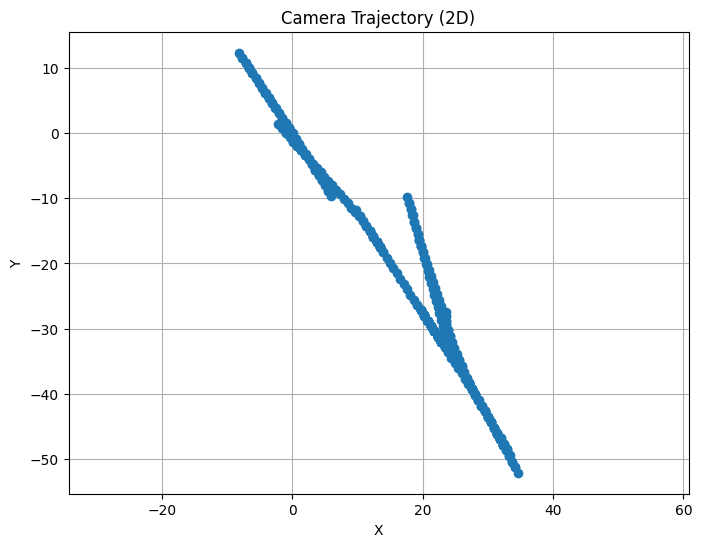

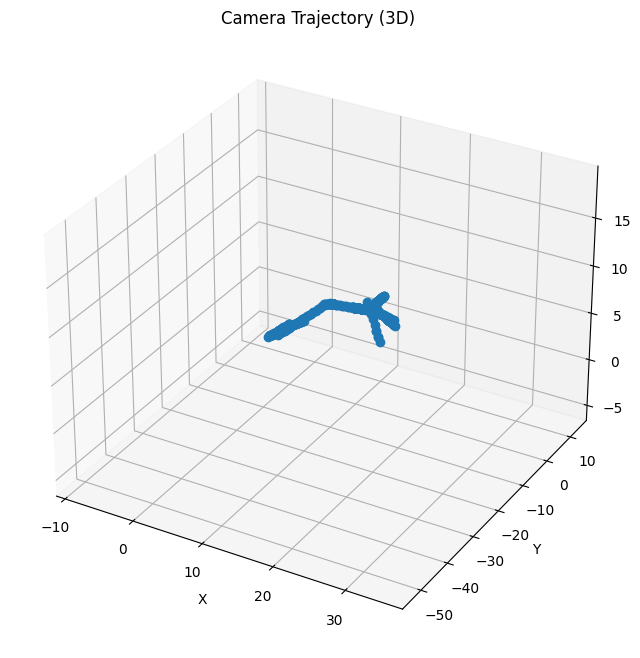

In [42]:
#visualize code!


# Extract x, y, and z coordinates of camera positions
x_coords = [pose[0, 3] for pose in camera_poses]
y_coords = [pose[1, 3] for pose in camera_poses]
z_coords = [pose[2, 3] for pose in camera_poses]

# Visualization in 2D
plt.figure(figsize=(8, 6))
plt.title('Camera Trajectory (2D)')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(x_coords, z_coords, '-o')
plt.grid(True)
plt.axis('equal')
plt.show()

# Visualization in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Camera Trajectory (3D)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(x_coords, z_coords, y_coords, marker='o')
plt.show()